In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Setting LC_CTYPE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/moog/moog.csv'
SAMPLES_FOLDER = '../data/moog/moog_samples/'
FOLDER_PREFIX = 'moog'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 16
N_MEL = 96

SUBSET = False
N_EPOCHS = 35
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

DEPENDENCIES = {}

RESULTS-moog-2018-01-11_16:13.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
if SUBSET:
    Y = Y.head(100)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   filter_reso  mixer_noise  mixer_osc2  mixer_osc1  env_amplifier_attack  \
0     0.698285     1.862296    2.768113    6.404199              1.648660   
1     4.970396     4.242202    0.766648    7.055484              3.825307   
2     4.577916     9.307819    7.043887    4.229384              3.269853   
3     8.953183     0.983947    8.842092    8.514924              0.371727   
4     6.111823     4.609046    2.621620    4.258072              1.008362   

  osc2_octave  env_amplifier_decay  filter_cutoff  mod_wave_amount  \
0          2f             1.513154       1.681011         7.167185   
1          2f             2.227309       6.105719         4.008423   
2          4f             3.631203       7.143991         5.766343   
3          2f             3.199658       3.233840         4.793383   
4          8f             6.661784       9.540377         2.125984   

   mod_lfo_rate   ...   osc1_wave  filter_kb_tracking_amount  \
0      3.447476   ...    9.203443                   

In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
(20, 19845)
Loaded training waveform #0
(80, 19845)


# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(20, 20, 39)
(80, 20, 39)


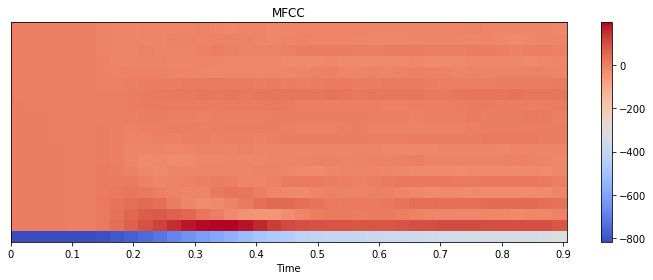

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[10,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(20, 780)
(80, 780)


## Predictions

In [8]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

    
def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):

        print 'predicting feature', t_name
        y_train = Y_train[t_name]
        y_test = Y_test[t_name]
        print y_train.dtype
        
        if t_name in DEPENDENCIES:
            switch = DEPENDENCIES[t_name]
            
            to_keep_train = (Y_train[switch] == 'on')
            print 'Keeping', str(sum(to_keep_train)), 'training examples out of',  str(len(to_keep_train))
            y_train = y_train[to_keep_train]
            X_train= X_train_mfcc[to_keep_train,...]
            
            to_keep_test = (Y_test[switch] == 'on')
            print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
            y_test = y_test[to_keep_test]
            X_test = X_test_mfcc[to_keep_test,...]
        
        else:
            X_train= X_train_mfcc
            X_test= X_test_mfcc
        
        print X_train.shape, y_train.shape
        print X_test.shape, y_test.shape
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [9]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature filter_reso
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... n_neighbors=16, total=   0.0s
2.75945578115
2.51244811695
('kNN', 'per_output', {'n_neighbors': 16}, None, None, 'mixer_osc2', 'reg', 2.7594557811453031, 2.512448116951616)
predicting feature mixer_osc1
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
1.96529685243
1.24895725244
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'env_amplifier_attack', 'reg', 1.9652968524283374, 1.2489572524356336)
predicting feature osc2_octave
object
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] ..

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
2.32123695294
2.35140084234
('kNN', 'per_output', {'n_neighbors': 5}, None, N

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... n_neighbors=16, total=   0.0s
0.6125
0.4
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'osc1_sync_osc2', 'class', 0.61250000000000004, 0.40000000000000002)
predicting feature env_amplifier_sustain
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] ..........

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
2.93541132576
3.07206021486
('kNN', 'per_output', {'n_neighbors': 16}, None, 

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
2.32584335388
2.66081710716
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'mod_filter_amount', 'reg', 2.3258433538827985, 2.6608171071646165)
predicting feature mod_source
object
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] ......

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


2.60535310993
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'filter_eg_amount', 'reg', 2.089973855012575, 2.605353109932)
predicting feature osc2_wave
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ............

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
2.27315376457
2.88958829274
('kNN', 'per_output', {'n_neighbors': 16}, None, None, 'env_amplifier_release', 'reg', 2.2731537645731597, 2.8895882927430545)
predicting feature mod_pitch_amount
float64
(80, 780) (80,)
(20,

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


In [10]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature filter_reso
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] 

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] m

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] m

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] m

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished


In [11]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature filter_reso
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.52506946532
2.51458447781
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'filter_reso', 'reg', 2.5250694653183716, 2.5145844778133495)
predicting feature mixer_noise
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean .....

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]


2.37671366661
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'env_amplifier_decay', 'reg', 2.4700847416745537, 2.376713666605911)
predicting feature filter_cutoff
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.45760303148
2.4928767625
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'filter_cutoff', 'reg', 2.4576030314785116, 2.4928767624968193)
predicting feature mod_wave_amount
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mea

2.3241164142


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1

2.57304675578
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'osc1_wave', 'reg', 2.3241164141996777, 2.5730467557824737)
predicting feature filter_kb_tracking_amount
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.5863806174
1.99821842764
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'filter_kb_tracking_amount', 'reg', 2.5863806173951587, 1.9982184276391393)
predicting feature env_filter_attack
float64
(80, 780) (80,)
(20, 780) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]

# Joint modelling

In [12]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

filter_reso
mixer_noise
mixer_osc2
mixer_osc1
env_amplifier_attack
osc2_octave
env_amplifier_decay
filter_cutoff
mod_wave_amount
mod_lfo_rate
osc1_sync_osc2
env_amplifier_sustain
mod_pitch_osc2
env_filter_sustain
mixer_sub
env_filter_release
osc2_frequency
osc1_octave
mod_filter_amount
mod_source
osc1_wave
filter_kb_tracking_amount
env_filter_attack
env_filter_decay
filter_eg_amount
osc2_wave
filter_multidrive
env_amplifier_release
mod_pitch_amount
OrderedDict([('filter_reso', {'sd': 2.9144787744309992, 'type': dtype('float64'), 'mean': 4.8169215039982127}), ('mixer_noise', {'sd': 3.1121909991209433, 'type': dtype('float64'), 'mean': 4.7991897088444855}), ('mixer_osc2', {'sd': 3.0303766254423876, 'type': dtype('float64'), 'mean': 4.6693676371843065}), ('mixer_osc1', {'sd': 2.7751550450817226, 'type': dtype('float64'), 'mean': 4.8760300311302878}), ('env_amplifier_attack', {'sd': 2.9042877117791339, 'type': dtype('float64'), 'mean': 4.7973432826708118}), ('osc2_octave', {'char2int': {'4

In [13]:
# Preps input data
X_train_mfcc = X_train_mfcc.reshape([X_train_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)
X_test_mfcc = X_test_mfcc.reshape([X_test_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)

print ''
print X_train_mfcc.shape
print X_test_mfcc.shape


(80, 39, 20)
(20, 39, 20)


In [14]:
from keras.callbacks import EarlyStopping

def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():

        # Normalizes/one-hot encodes
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1        
        else:
            raise ValueError
        
        # Sets to zero if necessary
        if name in DEPENDENCIES:
            switch = DEPENDENCIES[name]
            is_off = Y[switch] == "off"
            print 'Setting', str(sum(is_off)),'elements to zero'
            y[is_off] = 0
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model, X_train, X_test):
    
    try:
        # Prepares input and output data
        X_mean = np.mean(X_train, axis=(0))
        X_sd = np.std(X_train, axis=(0))

        X_train = (X_train - X_mean) / X_sd
        X_test  = (X_test - X_mean) / X_sd

        Y_dict_train = format_output(Y_train)
        Y_dict_test  = format_output(Y_test)

        # Trains the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        hist = model.fit(X_train, Y_dict_train, 
                  epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
                 validation_split = VALIDATION, callbacks=[early_stopping])

        # Makes predictions
        pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

        # Gets validation and test scores (for each metric)
        Y = {}
        for j, Y_pred in enumerate(pred):
            print 'Output:', j
            t_name = Y_info.keys()[j]
            t_infos = Y_info[t_name]
            truth = Y_test[t_name]
            print t_name
            print Y_pred.shape

            if t_name in DEPENDENCIES:
                switch = DEPENDENCIES[t_name]

                to_keep_test = (Y_test[switch] == 'on')
                print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
                truth = truth[to_keep_test]
                Y_pred = Y_pred[to_keep_test,...]
                print Y_pred.shape, truth.shape

            if t_infos['type'] == 'float64':
                test_metric = 'reg'
                Y_pred = Y_pred.flatten()
                y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
                y_pred = y_pred.tolist()
                test_score = mean_absolute_error(y_pred, truth)

            elif t_infos['type'] == 'object':
                test_metric = 'class'
                y_i = np.argmax(Y_pred, axis=1)
                y_pred = [t_infos['int2char'][y] for y in y_i]
                test_score = accuracy_score(y_pred, truth)

            else:
                raise ValueError

            train_scores = -1 * hist.history['val_loss'][-1]
            out = (label, 'joint', params1, params2, regul,
                   t_name, test_metric, train_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

            Y[t_name] = y_pred
            
    except:
        print "Unexpected error:", sys.exc_info()[0]
        return
    
    return Y

Using TensorFlow backend.


In [15]:
def NN_output(h_layer):
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    
    # Adds on/off switches
    switches = []
    for name,infos in Y_info.iteritems():
        if not name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            switches.append(name)
            out_layers.append(out_layer)
            
        if not name in DEPENDENCIES and infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            switches.append(name)
            out_layers.append(out_layer)
            
    # Adds dependent switches and knobs
    dependent = []
    for name,infos in Y_info.iteritems():
        
        if name in DEPENDENCIES and infos['type'] == 'float64':
            pred_layer = Dense(1)(h_layer)
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'mean_squared_error'
            metrics[name] = 'mean_absolute_error'
            out_layers.append(out_layer)
            dependent.append(name)

        
        if name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            pred_layer = Dense(out_dim, activation='softmax')(h_layer)            
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            out_layers.append(out_layer)
            dependent.append(name)
        
    # Reorders everything
    all_out = switches + dependent
    ord_out = []
    for out_name in Y_info:
        o = out_layers[all_out.index(out_name)]
        ord_out.append(o)

    return ord_out, metrics, losses

In [ ]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten, Multiply, Lambda, RepeatVector
from keras import backend as K
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [64,90,128]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 39, 20)        0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 780)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 64)            49984                                        
____________________________________________________________________________________________________
filter_reso (Dense)              (None, 1)             65                                           
___________________________________________________________________________________________

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s
Output: 0
filter_reso
(20, 1)
('MLP', 'joint', 64, 1, 0, 'filter_reso', 'reg', -35.920265197753906, 4.3284834288982648)
Output: 1
mixer_noise
(20, 1)
('MLP', 'joint', 64, 1, 0, 'mixer_noise', 'reg', -35.920265197753906, 2.7984068946748168)
Output: 2
mixer_osc2
(20, 1)
('MLP', 'joint', 64, 1, 0, 'mixer_osc2', 'reg', -35.920265197753906, 2.3559488998774873)
Output: 3
mixer_osc1
(20, 1)
('MLP', 'joint', 64, 1, 0, 'mixer_osc1', 'reg', -35.920265197753906, 3.2226400991427604)
Output: 4
env_amplifier_attack
(20, 1)
('MLP', 'joint', 64, 1, 0, 'env_amplifier_attack', 'reg', -35.920265197753906, 2.4348012136178818)
Output: 5
osc2_octave
(20, 4)
('MLP', 'joint', 64, 1, 0, 'osc2_octave', 'class', -35.920265197753906, 0.20000000000000001)
Output: 6
env_amplifier_decay
(20, 1)
('MLP', 'joint', 64, 1, 0, 'env_amplifier_decay', 'reg', -35.920265197753906, 2.9412344351104367)
Output: 7
filter_cutoff
(20, 1

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s
Output: 0
filter_reso
(20, 1)
('MLP', 'joint', 90, 1, 0, 'filter_reso', 'reg', -33.813751220703125, 2.8908215042417509)
Output: 1
mixer_noise
(20, 1)
('MLP', 'joint', 90, 1, 0, 'mixer_noise', 'reg', -33.813751220703125, 3.2846407610794714)
Output: 2
mixer_osc2
(20, 1)
('MLP', 'joint', 90, 1, 0, 'mixer_osc2', 'reg', -33.813751220703125, 2.7844430291285165)
Output: 3
mixer_osc1
(20, 1)
('MLP', 'joint', 90, 1, 0, 'mixer_osc1', 'reg', -33.813751220703125, 3.6782780100825017)
Output: 4
env_amplifier_attack
(20, 1)
('MLP', 'joint', 90, 1, 0, 'env_amplifier_attack', 'reg', -33.813751220703125, 2.9780533945071639)
Output: 5
osc2_octave
(20, 4)
('MLP', 'joint', 90, 1, 0, 'osc2_octave', 'class', -33.813751220703125, 0.0)
Output: 6
env_amplifier_decay
(20, 1)
('MLP', 'joint', 90, 1, 0, 'env_amplifier_decay', 'reg', -33.813751220703125, 4.0680542421224928)
Output: 7
filter_cutoff
(20, 1)
('MLP', 'joint

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s
Output: 0
filter_reso
(20, 1)
('MLP', 'joint', 128, 1, 0, 'filter_reso', 'reg', -35.178035736083984, 3.4480691376813466)
Output: 1
mixer_noise
(20, 1)
('MLP', 'joint', 128, 1, 0, 'mixer_noise', 'reg', -35.178035736083984, 3.0705893414205567)
Output: 2
mixer_osc2
(20, 1)
('MLP', 'joint', 128, 1, 0, 'mixer_osc2', 'reg', -35.178035736083984, 2.7107877022304145)
Output: 3
mixer_osc1
(20, 1)
('MLP', 'joint', 128, 1, 0, 'mixer_osc1', 'reg', -35.178035736083984, 3.2225178230494729)
Output: 4
env_amplifier_attack
(20, 1)
('MLP', 'joint', 128, 1, 0, 'env_amplifier_attack', 'reg', -35.178035736083984, 2.1065607565302611)
Output: 5
osc2_octave
(20, 4)
('MLP', 'joint', 128, 1, 0, 'osc2_octave', 'class', -35.178035736083984, 0.14999999999999999)
Output: 6
env_amplifier_decay
(20, 1)
('MLP', 'joint', 128, 1, 0, 'env_amplifier_decay', 'reg', -35.178035736083984, 4.3665790342016777)
Output: 7
filter_cutoff

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s
Output: 0
filter_reso
(20, 1)
('MLP', 'joint', 64, 2, 0, 'filter_reso', 'reg', -33.762035369873047, 3.0331107509193371)
Output: 1
mixer_noise
(20, 1)
('MLP', 'joint', 64, 2, 0, 'mixer_noise', 'reg', -33.762035369873047, 3.2457196877258108)
Output: 2
mixer_osc2
(20, 1)
('MLP', 'joint', 64, 2, 0, 'mixer_osc2', 'reg', -33.762035369873047, 2.9744072244290209)
Output: 3
mixer_osc1
(20, 1)
('MLP', 'joint', 64, 2, 0, 'mixer_osc1', 'reg', -33.762035369873047, 2.9520021941590358)
Output: 4
env_amplifier_attack
(20, 1)
('MLP', 'joint', 64, 2, 0, 'env_amplifier_attack', 'reg', -33.762035369873047, 3.6539991647921282)
Output: 5
osc2_octave
(20, 4)
('MLP', 'joint', 64, 2, 0, 'osc2_octave', 'class', -33.762035369873047, 0.45000000000000001)
Output: 6
env_amplifier_decay
(20, 1)
('MLP', 'joint', 64, 2, 0, 'env_amplifier_decay', 'reg', -33.762035369873047, 2.6103614362883349)
Output: 7
filter_cutoff
(20, 1

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s
Output: 0
filter_reso
(20, 1)
('MLP', 'joint', 90, 2, 0, 'filter_reso', 'reg', -32.908172607421875, 3.194474910531754)
Output: 1
mixer_noise
(20, 1)
('MLP', 'joint', 90, 2, 0, 'mixer_noise', 'reg', -32.908172607421875, 2.8051698107027327)
Output: 2
mixer_osc2
(20, 1)
('MLP', 'joint', 90, 2, 0, 'mixer_osc2', 'reg', -32.908172607421875, 3.1968001908611705)
Output: 3
mixer_osc1
(20, 1)
('MLP', 'joint', 90, 2, 0, 'mixer_osc1', 'reg', -32.908172607421875, 3.31866246723414)
Output: 4
env_amplifier_attack
(20, 1)
('MLP', 'joint', 90, 2, 0, 'env_amplifier_attack', 'reg', -32.908172607421875, 2.5074538369696815)
Output: 5
osc2_octave
(20, 4)
('MLP', 'joint', 90, 2, 0, 'osc2_octave', 'class', -32.908172607421875, 0.10000000000000001)
Output: 6
env_amplifier_decay
(20, 1)
('MLP', 'joint', 90, 2, 0, 'env_amplifier_decay', 'reg', -32.908172607421875, 3.2402863985101065)
Output: 7
filter_cutoff
(20, 1)
(

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s
Output: 0
filter_reso
(20, 1)
('MLP', 'joint', 128, 2, 0, 'filter_reso', 'reg', -29.371927261352539, 2.943130630688723)
Output: 1
mixer_noise
(20, 1)
('MLP', 'joint', 128, 2, 0, 'mixer_noise', 'reg', -29.371927261352539, 3.1866124228879071)
Output: 2
mixer_osc2
(20, 1)
('MLP', 'joint', 128, 2, 0, 'mixer_osc2', 'reg', -29.371927261352539, 2.6908904111880516)
Output: 3
mixer_osc1
(20, 1)
('MLP', 'joint', 128, 2, 0, 'mixer_osc1', 'reg', -29.371927261352539, 3.910480765154154)
Output: 4
env_amplifier_attack
(20, 1)
('MLP', 'joint', 128, 2, 0, 'env_amplifier_attack', 'reg', -29.371927261352539, 2.3051185740350748)
Output: 5
osc2_octave
(20, 4)
('MLP', 'joint', 128, 2, 0, 'osc2_octave', 'class', -29.371927261352539, 0.25)
Output: 6
env_amplifier_decay
(20, 1)
('MLP', 'joint', 128, 2, 0, 'env_amplifier_decay', 'reg', -29.371927261352539, 2.2110312342099951)
Output: 7
filter_cutoff
(20, 1)
('MLP', 

In [ ]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, dropout=regul)(h_layer)
        
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,80,128]:
        for REGUL in [0,0.2]:
            in_dim = X_train_mfcc.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 39, 20)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32)            6784                                         
____________________________________________________________________________________________________
filter_reso (Dense)              (None, 1)             33                                           
____________________________________________________________________________________________________
mixer_noise (Dense)              (None, 1)             33                                           
___________________________________________________________________________________________

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s
Output: 0
filter_reso
(20, 1)
('LSTM', 'joint', 32, 1, 0.2, 'filter_reso', 'reg', -27.388801574707031, 2.7979380020901035)
Output: 1
mixer_noise
(20, 1)
('LSTM', 'joint', 32, 1, 0.2, 'mixer_noise', 'reg', -27.388801574707031, 2.7782324153934406)
Output: 2
mixer_osc2
(20, 1)
('LSTM', 'joint', 32, 1, 0.2, 'mixer_osc2', 'reg', -27.388801574707031, 3.4055439764595676)
Output: 3
mixer_osc1
(20, 1)
('LSTM', 'joint', 32, 1, 0.2, 'mixer_osc1', 'reg', -27.388801574707031, 3.0853545328128043)
Output: 4
env_amplifier_attack
(20, 1)
('LSTM', 'joint', 32, 1, 0.2, 'env_amplifier_attack', 'reg', -27.388801574707031, 2.4443612946390179)
Output: 5
osc2_octave
(20, 4)
('LSTM', 'joint', 32, 1, 0.2, 'osc2_octave', 'class', -27.388801574707031, 0.20000000000000001)
Output: 6
env_amplifier_decay
(20, 1)
('LSTM', 'joint', 32, 1, 0.2, 'env_amplifier_decay', 'reg', -27.388801574707031, 2.5571367150346118)
Output: 7

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s
Output: 0
filter_reso
(20, 1)
('LSTM', 'joint', 64, 1, 0, 'filter_reso', 'reg', -27.834877014160156, 2.6219823451150566)
Output: 1
mixer_noise
(20, 1)
('LSTM', 'joint', 64, 1, 0, 'mixer_noise', 'reg', -27.834877014160156, 2.8402580664413257)
Output: 2
mixer_osc2
(20, 1)
('LSTM', 'joint', 64, 1, 0, 'mixer_osc2', 'reg', -27.834877014160156, 2.7607661539650605)
Output: 3
mixer_osc1
(20, 1)
('LSTM', 'joint', 64, 1, 0, 'mixer_osc1', 'reg', -27.834877014160156, 3.3996569778847752)
Output: 4
env_amplifier_attack
(20, 1)
('LSTM', 'joint', 64, 1, 0, 'env_amplifier_attack', 'reg', -27.834877014160156, 2.3265825714542618)
Output: 5
osc2_octave
(20, 4)
('LSTM', 'joint', 64, 1, 0, 'osc2_octave', 'class', -27.834877014160156, 0.20000000000000001)
Output: 6
env_amplifier_decay
(20, 1)
('LSTM', 'joint', 64, 1, 0, 'env_amplifier_decay', 'reg', -27.834877014160156, 2.3642474255374943)
Output: 7
filter_cutoff

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s
Output: 0
filter_reso
(20, 1)
('LSTM', 'joint', 64, 1, 0.2, 'filter_reso', 'reg', -27.638893127441406, 2.5987322830851305)
Output: 1
mixer_noise
(20, 1)
('LSTM', 'joint', 64, 1, 0.2, 'mixer_noise', 'reg', -27.638893127441406, 2.8670431572948383)
Output: 2
mixer_osc2
(20, 1)
('LSTM', 'joint', 64, 1, 0.2, 'mixer_osc2', 'reg', -27.638893127441406, 3.1503389749436468)
Output: 3
mixer_osc1
(20, 1)
('LSTM', 'joint', 64, 1, 0.2, 'mixer_osc1', 'reg', -27.638893127441406, 3.132740908765439)
Output: 4
env_amplifier_attack
(20, 1)
('LSTM', 'joint', 64, 1, 0.2, 'env_amplifier_attack', 'reg', -27.638893127441406, 2.3399913085817365)
Output: 5
osc2_octave
(20, 4)
('LSTM', 'joint', 64, 1, 0.2, 'osc2_octave', 'class', -27.638893127441406, 0.20000000000000001)
Output: 6
env_amplifier_decay
(20, 1)
('LSTM', 'joint', 64, 1, 0.2, 'env_amplifier_decay', 'reg', -27.638893127441406, 2.3795543538711215)
Output: 7


Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s
Output: 0
filter_reso
(20, 1)
('LSTM', 'joint', 80, 1, 0, 'filter_reso', 'reg', -27.173313140869141, 2.7628144520172944)
Output: 1
mixer_noise
(20, 1)
('LSTM', 'joint', 80, 1, 0, 'mixer_noise', 'reg', -27.173313140869141, 2.7833361346279069)
Output: 2
mixer_osc2
(20, 1)
('LSTM', 'joint', 80, 1, 0, 'mixer_osc2', 'reg', -27.173313140869141, 2.8148920828438451)
Output: 3
mixer_osc1
(20, 1)
('LSTM', 'joint', 80, 1, 0, 'mixer_osc1', 'reg', -27.173313140869141, 3.3652322914528896)
Output: 4
env_amplifier_attack
(20, 1)
('LSTM', 'joint', 80, 1, 0, 'env_amplifier_attack', 'reg', -27.173313140869141, 2.5233883695906369)
Output: 5
osc2_octave
(20, 4)
('LSTM', 'joint', 80, 1, 0, 'osc2_octave', 'class', -27.173313140869141, 0.34999999999999998)
Output: 6
env_amplifier_decay
(20, 1)
('LSTM', 'joint', 80, 1, 0, 'env_amplifier_decay', 'reg', -27.173313140869141, 2.5407752143523838)
Output: 7
filter_cutoff

Train on 72 samples, validate on 8 samples
Epoch 1/1
Unexpected error: <type 'exceptions.KeyboardInterrupt'>
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 39, 20)        0                                            
____________________________________________________________________________________________________
lstm_7 (LSTM)                    (None, 128)           76288                                        
____________________________________________________________________________________________________
filter_reso (Dense)              (None, 1)             129                                          
____________________________________________________________________________________________________
mixer_noise (Dense)              (None, 1)             129                         

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 2s
Output: 0
filter_reso
(20, 1)
('LSTM', 'joint', 128, 1, 0.2, 'filter_reso', 'reg', -27.251537322998047, 2.4741104356815846)
Output: 1
mixer_noise
(20, 1)
('LSTM', 'joint', 128, 1, 0.2, 'mixer_noise', 'reg', -27.251537322998047, 3.0185879872100636)
Output: 2
mixer_osc2
(20, 1)
('LSTM', 'joint', 128, 1, 0.2, 'mixer_osc2', 'reg', -27.251537322998047, 2.7426673338536118)
Output: 3
mixer_osc1
(20, 1)
('LSTM', 'joint', 128, 1, 0.2, 'mixer_osc1', 'reg', -27.251537322998047, 3.478183188669687)
Output: 4
env_amplifier_attack
(20, 1)
('LSTM', 'joint', 128, 1, 0.2, 'env_amplifier_attack', 'reg', -27.251537322998047, 2.3431550004960715)
Output: 5
osc2_octave
(20, 4)
('LSTM', 'joint', 128, 1, 0.2, 'osc2_octave', 'class', -27.251537322998047, 0.34999999999999998)
Output: 6
env_amplifier_decay
(20, 1)
('LSTM', 'joint', 128, 1, 0.2, 'env_amplifier_decay', 'reg', -27.251537322998047, 2.5061427303967507)
Out

In [ ]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul, in_shape):
    # Input layer
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer_full)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [16,32,48,64]:
    for N_LAYERS in [1,2]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

# Mid level features

In [ ]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

In [ ]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

In [ ]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

In [ ]:
for N_LAYERS in [1,2]:
    for N_UNITS in [64,90,128]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

In [ ]:
for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,80,128]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

In [ ]:
for N_FILTERS in [16,32,48,64]:
    for N_LAYERS in [1,2]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv_mid', N_FILTERS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

# Visualizing the results

In [ ]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p


In [ ]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)


# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
to_plot$family <- sapply(to_plot$algo,function(n){
    if (n%in%c('Conv', "LSTM", "MLP")){
        "joint model + MFCC"
    } else if (n%in%c('Conv_mid', "LSTM_mid", "MLP_mid")){
        "joint model + Mel Spectrum"
    } else{
        "Independent + MFCC"
    }
})

print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score, color=family, fill=family)) +
    geom_bar(stat='identity') +
    facet_grid(metric~family, scales='free')
print(p)

ggsave('results_moog.pdf', p, width=10)